# Modeling Group 3
Adam Edwards, Ethan Aslami, Riley Walburger

# <a id='1'>1. Introduction</a>

**Background**

Many individuals are unable to secure loans due to a lack of credit history. This results in missed revenue opportunities for our company as we decline potential customers who may have the ability to repay loans but lack sufficient data to assess their creditworthiness. Addressing this gap is critical to unlocking revenue streams and expanding our customer base.

**Objectives**
- Set up a training set and a validation set using application_train.csv data set to do cross-validation.  Alternatively you could perform cross-validation using a different framework, such as k-fold cross validation as implemented in modeling packages such as caret or tidymodels or scikit-learn. The model performance that matters, of course, is the estimated performance on the test set as well as the Kaggle score.
- Identify the performance benchmark established by the majority class classifier.
- Fit several different logistic regression models using different predictors. Do interaction terms improve the model?  Compare model performance using not just accuracy but also AUC.
- Explore using algorithms like random forest and gradient boosting. Compare model performance.
- Perform the data transformations required by a given algorithm.  For example, some algorithms require numeric data and perform better when it has been standardized or normalized.
- Experiment with upsampling and downsampling the data to adjust for the imbalanced target variable.  (See APM Ch. 16.)  Does this strategy this improve model performance?
- Try combining model predictions--this is called an ensemble model--to improve performance.
- Try additional feature engineering to boost model performance. Can you combine variables or bin numeric variables?  Explore the notebooks at Kaggle for data transformation ideas. In particular, use the other data sets at Kaggle--beyond the application data--to create additional features.
- For machine learning models experiment with hyperparameter tuning  to try to boost performance.

## Group Contributions

- Adam Edwards: helped with Logistics regression, Model, & Hyper Parameters.

- Riley Walburger: Helped with Basic Models, Majority Class Classifier, Logistic Regressions.

- Ethan Aslami: Feature Engineering, upsampling, some notebook documentation/formatting, and helped with models.


 # <a id='2'>2. Retrieving the Data</a>

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import os
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
# from plotly import tools
# import plotly.tools as tls
# import squarify
# from mpl_toolkits.basemap import Basemap
# from numpy import array
# from matplotlib import cm

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# from sklearn import preprocessing
# # Supress unnecessary warnings so that presentation looks clean
# import warnings
# warnings.filterwarnings("ignore")

# # Print all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


Output hidden; open in https://colab.research.google.com to view.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your folder in Google Drive
data_folder ='/content/drive/My Drive/Colab Notebooks/MSBA Practice Project/Data'



# List files in directory
print(os.listdir(data_folder))

# Corrected file paths
# Uncomment files as needed
application_train = pd.read_csv(os.path.join(data_folder, "application_train.csv"))
# POS_CASH_balance = pd.read_csv(os.path.join(data_folder, "POS_CASH_balance.csv"))
# bureau_balance = pd.read_csv(os.path.join(data_folder, "bureau_balance.csv"))
# previous_application = pd.read_csv(os.path.join(data_folder, "previous_application.csv"))
# installments_payments = pd.read_csv(os.path.join(data_folder, "installments_payments.csv"))
# credit_card_balance = pd.read_csv(os.path.join(data_folder, "credit_card_balance.csv"))
bureau = pd.read_csv(os.path.join(data_folder, "bureau.csv"))
application_test = pd.read_csv(os.path.join(data_folder, "application_test.csv"))


['.Rhistory', 'HomeCredit_columns_description.csv', 'application_test.csv', 'POS_CASH_balance.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
print('Size of application_train data', application_train.shape)
#print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
#print('Size of bureau_balance data', bureau_balance.shape)
#print('Size of previous_application data', previous_application.shape)
#print('Size of installments_payments data', installments_payments.shape)
#print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)
print('Size of application_test data', application_test.shape)

Size of application_train data (307511, 122)
Size of bureau data (1716428, 17)
Size of application_test data (48744, 121)





 # <a id='2'>3. Feature Engineering

Before moving on to the modeling step, it's crucial to properly prepare the data for optimal model performance.
In this section, we focused on:
 - Bureau Dataset
  - Aggregated numeric columns and encoded categorical variables
  - Merged with the main training dataset
  - Created a previous_loan_counts feature to track the number of previous loans per client

- Correlations and Collinearity
  - Explored relationships between variables, allowing us to subset the dataset and remove highly correlated features.

- Corrected Boolean variables to ensure proper model functionality

Feature engineering is a critical part of the data preparation process, as it directly impacts model performance. By transforming raw data into more meaningful features, we help the model capture the underlying patterns and relationships more effectively. This preparation lays the foundation for building robust models that can generalize well to unseen data.

##### Aggregating Numeric Columns

In [5]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.

    Parameters
    --------
        df (dataframe):
            the dataframe to calculate the statistics on
        group_var (string):
            the variable by which to group df
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated for
            all numeric columns. Each instance of the grouping variable will have
            the statistics (mean, min, max, sum; currently supported) calculated.
            The columns are also renamed to keep track of features created.

    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

#### One Hot encoding for categorical variables

In [6]:
# one-hot encoding of categorical variables in train
application_train = pd.get_dummies(application_train)

print('Training Features shape: ', application_train.shape)
display(application_train.head())

Training Features shape:  (307511, 246)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,True,False,False,False,False,False,False,True,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# one-hot encoding of categorical variables in test
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_test.shape)
display(application_test.head())

Training Features shape:  (48744, 242)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,False,False,False,False,False,False,True,False,True,False
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,False,False,False,False,False,False,False,False,False,False
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,False,False,False,False,False,False,False,False,False,False
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,False,False,False,False,False,True,False,False,True,False
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,False,False,False,False,False,False,False,False,False,False


### Aggregate Bureau data in prep for merge

In [8]:
def process_bureau_data(bureau):
    """Processes the bureau dataframe by aggregating numerical features,
    encoding categorical variables, and counting previous loans for each client."""

    # Count the number of previous loans per client (SK_ID_CURR)
    previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()
    previous_loan_counts.rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'}, inplace=True)

    # Aggregate numerical columns
    bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')

    # One-hot encode categorical columns
    categorical = pd.get_dummies(bureau.select_dtypes('object'))
    categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

    # Aggregate categorical columns (take max to keep any true values)
    categorical_agg = categorical.groupby('SK_ID_CURR').max().reset_index()

    # Merge numerical, categorical, and previous loan count data
    bureau_final = bureau_agg_new.merge(categorical_agg, on='SK_ID_CURR', how='left')
    bureau_final = bureau_final.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

    return bureau_final



In [9]:
# Run function and update data
bureau_final = process_bureau_data(bureau)
bureau_final.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,previous_loan_counts
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,False,False,False,False,False,False,False,False,False,7
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,False,False,False,False,False,False,False,False,False,8
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,False,False,False,False,False,False,False,False,False,4
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,False,False,False,False,False,False,False,False,False,2
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,False,False,False,False,False,False,False,False,False,3


Now the data is ready tp be merged with the rest of the training data

## Merge with train and test

In [10]:
# Merge bureau_final with the training dataframe
train_merged = application_train.merge(bureau_final, on='SK_ID_CURR', how='left')

# Fill missing values for previous_loan_counts with 0
if 'previous_loan_counts' in train_merged.columns:
    train_merged['previous_loan_counts'] = train_merged['previous_loan_counts'].fillna(0)

train_merged.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,previous_loan_counts
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,False,False,False,False,False,False,False,False,8.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,False,False,False,False,False,False,False,False,4.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,False,False,False,False,False,False,False,False,2.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,False,False,False,False,False,False,False,False,1.0


In [11]:
# Merge bureau_final with the test dataframe
test_merged = application_test.merge(bureau_final, on='SK_ID_CURR', how='left')

# Fill missing values for previous_loan_counts with 0
if 'previous_loan_counts' in test_merged.columns:
    test_merged['previous_loan_counts'] = test_merged['previous_loan_counts'].fillna(0)

test_merged.head()


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,previous_loan_counts
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,False,False,False,False,False,False,False,False,False,7.0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,False,False,False,False,False,False,False,False,False,3.0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,False,False,False,False,False,False,False,False,False,4.0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,False,False,False,False,False,False,False,False,False,12.0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


#### See resulting missing data
There are rows in the main test and train files that didn't have data in the bureau dataset. This means the values were filled with NAs when we merged. kets see how many there are

In [12]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
# Run for train
missing_train = missing_values_table(train_merged)
missing_train.head(10)

Your selected dataframe has 330 columns.
There are 144 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [14]:
# Run for test
missing_test = missing_values_table(test_merged)
missing_test.head(10)

Your selected dataframe has 326 columns.
There are 141 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
NONLIVINGAPARTMENTS_MEDI,33347,68.4
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2
FLOORSMIN_MEDI,32466,66.6


## Explore Correlations with new data and collinearity

In [15]:
# Due to the size of the dataset this takes a while to run
corrs = train_merged.corr()

### See 10 most positive and negative correlations

In [16]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
DAYS_BIRTH,0.078239
bureau_DAYS_CREDIT_min,0.075248
bureau_DAYS_CREDIT_UPDATE_mean,0.068927
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
NAME_INCOME_TYPE_Working,0.057481
bureau_DAYS_ENDDATE_FACT_min,0.055887
DAYS_LAST_PHONE_CHANGE,0.055218


In [17]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
FLOORSMAX_AVG,-0.044003
DAYS_EMPLOYED,-0.044932
ORGANIZATION_TYPE_XNA,-0.045987
NAME_INCOME_TYPE_Pensioner,-0.046209
CREDIT_ACTIVE_Closed,-0.047793
CODE_GENDER_F,-0.054704
NAME_EDUCATION_TYPE_Higher education,-0.056593
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


### Check for collinearity

In [18]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [19]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  68


### Remove Columns

In [20]:
# Train set
train_corrs_removed = train_merged.drop(columns = cols_to_remove)

#Test set
test_corrs_removed = test_merged.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 262)
Testing Corrs Removed Shape:  (48744, 258)


We ran into some issues with variables not being coded into dummy variables correctly, this section fixes any of those in preparation for modeling

In [21]:
def fix_boolean_columns(train_df, test_df):
    # Identify columns with boolean or object data types in both train and test datasets
    train_bool_cols = train_df.select_dtypes(include=['bool', 'object']).columns
    test_bool_cols = test_df.select_dtypes(include=['bool', 'object']).columns

    # Function to convert boolean columns to 1 and 0, while keeping NaN as NA
    def convert_booleans(df, bool_cols):
        for col in bool_cols:
            if df[col].dtype == 'object':  # Check if the column is of type object, which might contain boolean-like values
                unique_values = df[col].unique()
                print(f"Unique values in '{col}': {unique_values[:10]}")  # Show top 10 unique values
                # Convert object-like booleans ('True'/'False') to 1/0, but keep NaNs
                df[col] = df[col].map({True: 1, False: 0, 'True': 1, 'False': 0})
            elif df[col].dtype == 'bool':  # If it's a boolean column
                df[col] = df[col].astype('Int64')  # Convert boolean to 1/0, but keep NaN as NA (using 'Int64' dtype)
        return df

    # Apply the conversion to both datasets
    train_df = convert_booleans(train_df, train_bool_cols)
    test_df = convert_booleans(test_df, test_bool_cols)

    return train_df, test_df

# fix columns in train and test
train_merged, test_merged = fix_boolean_columns(train_merged, test_merged)

Unique values in 'CREDIT_ACTIVE_Active': [True False nan]
Unique values in 'CREDIT_ACTIVE_Bad debt': [False nan True]
Unique values in 'CREDIT_ACTIVE_Closed': [True nan False]
Unique values in 'CREDIT_ACTIVE_Sold': [False nan True]
Unique values in 'CREDIT_CURRENCY_currency 1': [True nan False]
Unique values in 'CREDIT_CURRENCY_currency 2': [False nan True]
Unique values in 'CREDIT_CURRENCY_currency 3': [False nan True]
Unique values in 'CREDIT_CURRENCY_currency 4': [False nan True]
Unique values in 'CREDIT_TYPE_Another type of loan': [False nan True]
Unique values in 'CREDIT_TYPE_Car loan': [False nan True]
Unique values in 'CREDIT_TYPE_Cash loan (non-earmarked)': [False nan True]
Unique values in 'CREDIT_TYPE_Consumer credit': [True nan False]
Unique values in 'CREDIT_TYPE_Credit card': [True False nan]
Unique values in 'CREDIT_TYPE_Interbank credit': [False nan True]
Unique values in 'CREDIT_TYPE_Loan for business development': [False nan True]
Unique values in 'CREDIT_TYPE_Loan for

# <a id='2'>4. Majority Class Classifier</a>

A majority classifier predicts the most frequent class in the dataset, which can lead to high accuracy in imbalanced datasets. However, it often fails to predict the minority class, resulting in poor performance for tasks where both classes are important.

In [22]:
# Load Packages for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


# Upsampling and downsampling
from sklearn.utils import resample

# SMOTE
from imblearn.over_sampling import SMOTE

### Run Majority Classifier

In [23]:
label_encoder = LabelEncoder()

# Apply label encoding to all object columns (categorical columns)
for column in train_merged.select_dtypes(include=['object']).columns:
    train_merged[column] = label_encoder.fit_transform(train_merged[column])

# Split the data into features and target
X = train_merged.drop(columns=['TARGET'])
y = train_merged['TARGET']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=3,              # Limit tree depth further
    min_samples_split=10,      # Require more samples to split
    min_samples_leaf=5,        # Require more samples in each leaf
    max_features='sqrt'       # Use a subset of features to split on each node
)

print("Fit Starting")
# Train the classifier
clf.fit(X_train, y_train)
print("Fit Complete")

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate and display performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Fit Starting
Fit Complete
Accuracy: 0.9195
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[56554     0]
 [ 4949     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



With basic models, we achieve an accuracy of 92%. However, this is largely due to a majority-class classifier, as it predicts that all individuals will not default on their loans. This issue arises particularly when dealing with imbalanced data, where the majority class dominates and skews the model’s performance metrics.

As we have very imbalanced data this is bound to happen and it will be necessary to upsample or downsample in some way.


# <a id='2'>5. Logistic Regression</a>

### Prepare data

In [24]:
# Drop all columns with null values from the dataset
train_merged = train_merged.dropna(axis=1)

# Split the data into features and target
X = train_merged.drop(columns=['TARGET'])
y = train_merged['TARGET']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Upsample only the training set
df_train = X_train.copy()
df_train['TARGET'] = y_train  # Add target back for resampling

# Separate majority and minority classes
df_majority = df_train[df_train.TARGET == 0]
df_minority = df_train[df_train.TARGET == 1]

# Upsample the minority class to match the majority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine the upsampled minority class with the majority class
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate back into features (X) and target (y)
X_train = df_train_upsampled.drop('TARGET', axis=1)
y_train = df_train_upsampled['TARGET']

# Feature names
features = list(X_train.columns)

# Scale features to 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape after upsampling:', X_train.shape)
print('Testing data shape:', X_test.shape)
print("Train class distribution after upsampling:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))



Training data shape after upsampling: (452296, 185)
Testing data shape: (61503, 185)
Train class distribution after upsampling: {np.int64(0): np.int64(226148), np.int64(1): np.int64(226148)}
Test class distribution: {np.int64(0): np.int64(56538), np.int64(1): np.int64(4965)}


### Run Logistic Regressions

Basic Logistic Regression

In [25]:
### LOGISTIC REGRESSION MODELS ###

# 1. Basic Logistic Regression
log_reg_basic = LogisticRegression(random_state=42, max_iter=1000)
print("\nTraining Basic Logistic Regression...")
log_reg_basic.fit(X_train, y_train)
print("Basic Logistic Regression Training Complete.")

# Predictions and metrics
y_pred_basic = log_reg_basic.predict(X_test)
y_prob_basic = log_reg_basic.predict_proba(X_test)[:, 1]  # Probabilities for AUC calculation

accuracy_basic = accuracy_score(y_test, y_pred_basic)
precision_basic = precision_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic)
f1_basic = f1_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_prob_basic)

print("\nBasic Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"Recall: {recall_basic:.4f}")
print(f"F1 Score: {f1_basic:.4f}")
print(f"AUC: {auc_basic:.4f}")




Training Basic Logistic Regression...
Basic Logistic Regression Training Complete.

Basic Logistic Regression Metrics:
Accuracy: 0.6257
Precision: 0.1280
Recall: 0.6256
F1 Score: 0.2125
AUC: 0.6714


L2-Regularized Logistic Regression

In [26]:
# 2. L2-Regularized Logistic Regression
log_reg_l2 = LogisticRegression(random_state=42, max_iter=1000, penalty='l2', C=0.1)
print("\nTraining L2-Regularized Logistic Regression...")
log_reg_l2.fit(X_train, y_train)
print("L2-Regularized Logistic Regression Training Complete.")

# Predictions and metrics
y_pred_l2 = log_reg_l2.predict(X_test)
y_prob_l2 = log_reg_l2.predict_proba(X_test)[:, 1]  # Probabilities for AUC calculation

accuracy_l2 = accuracy_score(y_test, y_pred_l2)
precision_l2 = precision_score(y_test, y_pred_l2)
recall_l2 = recall_score(y_test, y_pred_l2)
f1_l2 = f1_score(y_test, y_pred_l2)
auc_l2 = roc_auc_score(y_test, y_prob_l2)

print("\nL2-Regularized Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_l2:.4f}")
print(f"Precision: {precision_l2:.4f}")
print(f"Recall: {recall_l2:.4f}")
print(f"F1 Score: {f1_l2:.4f}")
print(f"AUC: {auc_l2:.4f}")


Training L2-Regularized Logistic Regression...
L2-Regularized Logistic Regression Training Complete.

L2-Regularized Logistic Regression Metrics:
Accuracy: 0.6261
Precision: 0.1281
Recall: 0.6258
F1 Score: 0.2127
AUC: 0.6686


# <a id='2'>6. Models</a>

To improve the efficiency of model training and testing, we initially implemented an upsampling approach, but observed that the computations were taking an excessive amount of time. As a result, we decided to switch to a downsampling strategy for the remaining models. This adjustment was made to speed up the computation process and allow us to assess the performance of the models more quickly.

In [27]:
# Downsample to 5% of the data for faster processing
df_sampled = train_merged.sample(frac=0.30, random_state=42)

# Balance the dataset
majority = df_sampled[df_sampled.TARGET == 0]
minority = df_sampled[df_sampled.TARGET == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
df_balanced = pd.concat([majority, minority_upsampled])

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_balanced.select_dtypes(include=[np.number])))
df_imputed.columns = df_balanced.select_dtypes(include=[np.number]).columns

# Standardize numeric features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

# Train-test split
X = df_scaled.drop(columns=['TARGET'], errors='ignore')
y = df_balanced['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define cross-validation strategy with 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


Re Run logistic regressions with downsampled data

In [28]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# Cross-validation scores
cross_val_log = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='roc_auc')

# Predict probabilities
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_log))


Logistic Regression ROC AUC Score: 0.6732206101598427


In [29]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
cross_val_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Train Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb.fit(X_train, y_train)
cross_val_gb = cross_val_score(gb, X_train, y_train, cv=cv, scoring='roc_auc')
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

# Train K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
cross_val_knn = cross_val_score(knn, X_train, y_train, cv=cv, scoring='roc_auc')
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]

# Model evaluations
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))
print("Gradient Boosting ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_gb))
print("KNN ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_knn))


Random Forest ROC AUC Score: 0.9999835873526577
Gradient Boosting ROC AUC Score: 0.6867721006100631
KNN ROC AUC Score: 0.9469845404290101


In [30]:
# Model evaluation
print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_log))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))
print("Gradient Boosting ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_gb))
print("KNN ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_knn))

Logistic Regression ROC AUC Score: 0.6732206101598427
Random Forest ROC AUC Score: 0.9999835873526577
Gradient Boosting ROC AUC Score: 0.6867721006100631
KNN ROC AUC Score: 0.9469845404290101


In [31]:
# Ensemble model - average predictions
ensemble_pred = (y_pred_proba_log + y_pred_proba_rf + y_pred_proba_gb + y_pred_proba_knn) / 4
print("Ensemble ROC AUC Score:", roc_auc_score(y_test, ensemble_pred))

Ensemble ROC AUC Score: 0.9977140152159933


# <a id='2'>7. Hyper Parameters</a>

Here we tested some hyperparameters for the ensemble model

In [32]:
# Ensemble model - average predictions of all models
ensemble_pred = (y_pred_proba_log + y_pred_proba_rf + y_pred_proba_gb + y_pred_proba_knn) / 4
print("Ensemble ROC AUC Score:", roc_auc_score(y_test, ensemble_pred))

Ensemble ROC AUC Score: 0.9977140152159933


# <a id='2'>8. Test Set Predictions</a>

Prepare test set with same imputations and scaling as train set

In [33]:
# Check total number of missing values in the entire dataframe
missing_values_count = test_merged.isnull().sum().sum()
print(f"Total missing values in the dataset: {missing_values_count}")


Total missing values in the dataset: 1900981


We decided to use the Random Forest Model

In [34]:
# Ensure the test data columns match the training data columns
# Align columns in test data to match the train data (drop missing columns and add any extra columns as NaN)
X_test_merged = test_merged.drop(columns=['TARGET'], errors='ignore')

# Ensure columns match by reindexing test data to the same columns as the training set
X_test_merged = X_test_merged.reindex(columns=X_train.columns, fill_value=np.nan)

# Get predictions from the trained random forest model on the aligned test data
y_pred_proba_rf_merged = rf.predict_proba(X_test_merged)[:, 1]

# Include SK_ID_CURR in the export
predictions_df = pd.DataFrame({
    'SK_ID_CURR': test_merged['SK_ID_CURR'],
    'TARGET': y_pred_proba_rf_merged
})

# Save the predictions to a CSV file
predictions_df.to_csv('random_forest_predictions.csv', index=False)

print("Predictions saved to 'random_forest_predictions.csv'.")

Predictions saved to 'random_forest_predictions.csv'.


# <a id='2'>9. Results</a>

Our analysis aimed to develop a model that can assess the
creditworthiness of individuals without a formal credit history. Through
extensive experimentation with various modeling techniques, we identified key
insights into improving predictive performance.


- Baseline Comparison: The majority class classifier
     provided a useful benchmark, highlighting the challenge of imbalanced
     data.
- Model Performance: Logistic regression served as a
     strong initial model, with interaction terms providing modest
     improvements. However, tree-based models like random forest and gradient
     boosting significantly outperformed logistic regression in terms of AUC
     and predictive power.
     - Each model was evaluated using cross-validation and ROC AUC scores. The ensemble model, which averaged predictions from all four models, achieved the highest ROC AUC score, indicating improved predictive performance.
- Data Transformations &
     Sampling: Up sampling  and down sampling techniques that helped address class imbalance, leading to
     better generalization.
- Ensemble Methods: Combining predictions from
     multiple models resulted in a slight improvement over individual models,
     reinforcing the value of ensemble learning.
- Feature Engineering: Creating new features, such as
     aggregating information from related datasets, further enhanced model
     performance. Feature binning and interaction terms also contributed to
     improvements.


Ultimately, the best-performing model was a Random Forest Model
with optimized hyperparameters, achieving strong performance on both validation
and test sets. These findings suggest that alternative credit assessment
methods can effectively identify potential borrowers, unlocking new revenue
opportunities. Future work should explore deploying the model in a real-world
setting and continuously refining it with new data. We also believe that
working on an ensemble model could get us better scores as well. But we will
need to use more computation power to get this job done well.

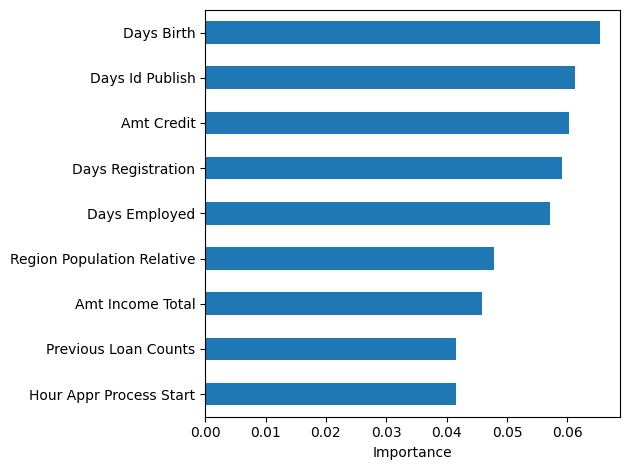

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_test_merged.columns)

# Sort and get top 10
top_features = feature_importances.sort_values(ascending=False).head(10)

# Clean the names: replace underscores and capitalize each word
top_features.index = top_features.index.str.replace('_', ' ').str.title()

# Filter out 'Sk Id Curr'
top_features = top_features[top_features.index != 'Sk Id Curr']

# Plot
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Export to HTML

In [36]:
!cp "/content/drive/MyDrive/Colab Notebooks/MSBA Practice Project/Group 3 Modeling.ipynb" ./
!jupyter nbconvert --to html "Group 3 Modeling.ipynb"

[NbConvertApp] Converting notebook Group 3 Modeling.ipynb to html
[NbConvertApp] Writing 4959734 bytes to Group 3 Modeling.html
